In [1]:
import warnings
warnings.filterwarnings("ignore", category=Warning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sktime.forecasting.all import temporal_train_test_split
import statsmodels.api as sm
import pmdarima as pm
from sktime.forecasting.arima import ARIMA
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [23]:
data = pd.read_csv('./data/FB.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-04-24,144.960007,145.669998,144.339996,145.470001,145.470001,14407200
1,2017-04-25,145.789993,147.149994,145.789993,146.490005,146.490005,17767500
2,2017-04-26,147.089996,147.589996,146.089996,146.559998,146.559998,12395000
3,2017-04-27,146.669998,147.750000,146.139999,147.699997,147.699997,11275100
4,2017-04-28,149.500000,151.529999,149.070007,150.250000,150.250000,30652200


In [3]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1254,2022-04-14,214.889999,214.990005,210.000000,210.179993,210.179993,18332700
1255,2022-04-18,210.000000,213.380005,208.300003,210.770004,210.770004,16580800
1256,2022-04-19,210.520004,218.429993,209.000000,217.309998,217.309998,20089900
1257,2022-04-20,213.610001,214.160004,198.919998,200.419998,200.419998,43036500
1258,2022-04-21,201.600006,202.970001,185.580002,188.070007,188.070007,49954100


Transform the Date column into DatetimeIndex.

In [24]:
data['Date'] = pd.to_datetime(data['Date'])
data.index = pd.core.indexes.period.PeriodIndex(data['Date'].tolist(), freq='B')

We will only use the close price for this project.

<AxesSubplot:>

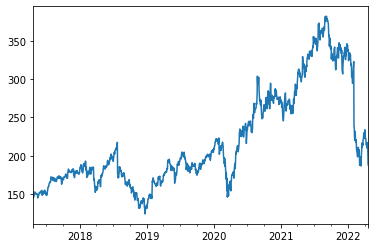

In [4]:
data['Close'].plot()

### ARIMA

Split the dataset into 80% train and 20% test.

In [4]:
y_train, y_test = temporal_train_test_split(data['Close'], train_size=0.8)

In [44]:
y_test.index

PeriodIndex(['2021-04-23', '2021-04-26', '2021-04-27', '2021-04-28',
             '2021-04-29', '2021-04-30', '2021-05-03', '2021-05-04',
             '2021-05-05', '2021-05-06',
             ...
             '2022-04-07', '2022-04-08', '2022-04-11', '2022-04-12',
             '2022-04-13', '2022-04-14', '2022-04-18', '2022-04-19',
             '2022-04-20', '2022-04-21'],
            dtype='period[B]', length=252)

In [11]:
y_train_diff = y_train.diff().dropna()

In [12]:
alpha=0.05

ad_fuller_results = adfuller(y_train_diff)
ad_fuller_pval = ad_fuller_results[1]
ad_fuller_bool = ad_fuller_pval <= alpha

print(f'stationarity from ad_fuller test: {ad_fuller_bool}')

stationarity from ad_fuller test: True


In [13]:
kpss_test_results = kpss(y_train_diff)
kpss_pval = kpss_test_results[1]
kpss_test_bool = kpss_pval >= alpha

print(f'stationarity from KPSS test: {kpss_test_bool}')

stationarity from KPSS test: True


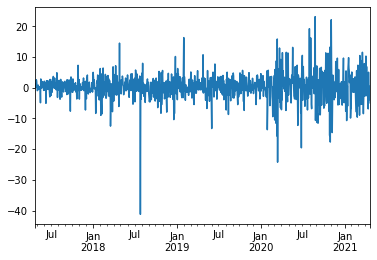

In [14]:
y_train_diff.plot()
plt.show()

Both the ADF and the KPSS test suggest the stationarity of the first-differenced data. Therefore, the non-seasonal differencing order should be 1. There is no seasonality.

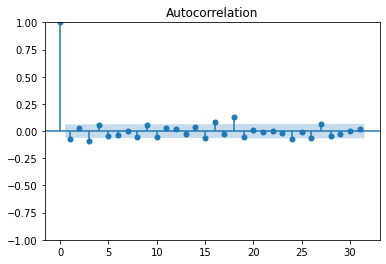

In [15]:
plot_acf(y_train_diff)
plt.show()

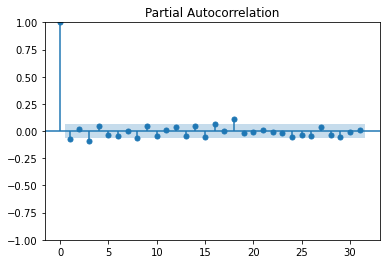

In [16]:
plot_pacf(y_train_diff)
plt.show()

In [ ]:
auto_arima_model = pm.auto_arima(y_train, D=1, m=12)

In [23]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1007
Model:               SARIMAX(4, 1, 2)   Log Likelihood               -2910.719
Date:                Fri, 13 May 2022   AIC                           5835.437
Time:                        11:24:34   BIC                           5869.833
Sample:                             0   HQIC                          5848.506
                               - 1007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6919      0.047    -36.348      0.000      -1.783      -1.601
ar.L2         -0.9256      0.068    -13.608      0.000      -1.059      -0.792
ar.L3         -0.1187      0.056     -2.114      0.034      -0.229      -0.009
ar.L4         -0.0710      0.032     -2.251      0.024      -0.133      -0.009
ma.L1          1.6432      0.044     37.119      0.000       1.556       1.730
ma.L2          0.8497      0.051     16.662      0.000       0.750       0.950
sigma2        19.0794      0.345     55.277      0.000      18.403      19.756
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5279.99
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.71   Skew:                            -0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The Auto ARIMA suggests an ARIMA(4,1,2) process.

In [40]:
arima_model = sm.tsa.statespace.SARIMAX(endog=y_train,order=(4,1,2))
arima_fit = arima_model.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1007
Model:               SARIMAX(4, 1, 2)   Log Likelihood               -2910.719
Date:                Fri, 13 May 2022   AIC                           5835.437
Time:                        11:40:37   BIC                           5869.833
Sample:                    04-24-2017   HQIC                          5848.506
                         - 04-22-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6919      0.047    -36.348      0.000      -1.783      -1.601
ar.L2         -0.9256      0.068    -13.608      0.000      -1.059      -0.792
ar.L3         -0.1187      0.056     -2.114      0.0

In [32]:
resid = arima_fit.resid
resid.head()

2017-04-24    145.470001
2017-04-25      1.020211
2017-04-26      0.143404
2017-04-27      1.124715
2017-04-28      2.715867
Freq: B, dtype: float64

<AxesSubplot:>

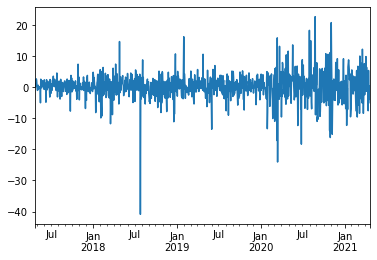

In [33]:
resid = resid[1:]
resid.plot()

<AxesSubplot:>

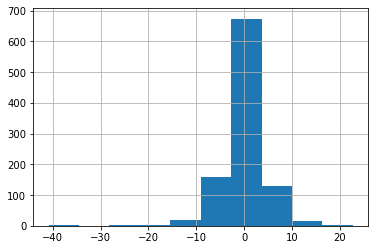

In [34]:
resid.hist()

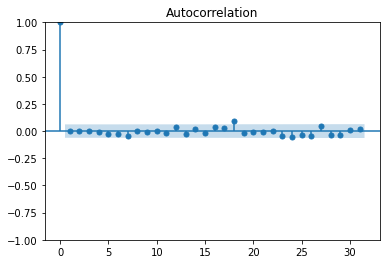

In [35]:
plot_acf(resid)
plt.show()

In [36]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,3.179971,0.976866,3.153866,0.977568


The plot of residuals show a stationary process. The histogram indicates some outliers. The ACF plot does not show significant lag values larger than 0. The p-value from Ljung Box is significantly larger than 0.05, indicating there is no lack of fit and that the model is a good fit.

In [41]:
y_pred=arima_fit.forecast(steps = len(y_test))

<AxesSubplot:>

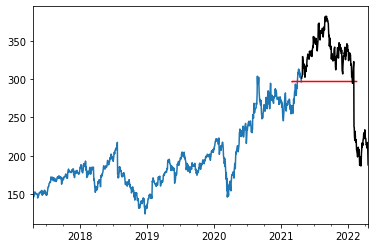

In [46]:
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

The prediction on the test set is close to constant and does not capture the changes.

In [31]:
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')
mape = mean_absolute_percentage_error(y_test, y_pred, symmetric=False)
print(f'MAPE: {mape}')
smape = mean_absolute_percentage_error(y_test, y_pred)
print(f'SMAPE: {smape}')

MAE: 50.37304828770446
MSE: 3185.7359903315537
MAPE: 0.17919219847827825
SMAPE: 0.17150823793527356


## External Variables

In [25]:
event = pd.read_csv('./data/event_dates.csv')
event.head()

,events,dates
0,Q1 2022 Earnings,27-Apr-22
1,Q4 2021 Earnings,2-Feb-22
2,Facebook changes name to Meta,1-Dec-21
3,Facebook Connect 2021 (announce new name),28-Oct-21
4,Q3 2021 Earnings,25-Oct-21


In [26]:
event['events'] = 1
event['dates'] = pd.to_datetime(event['dates'])
event.head()

,events,dates
0,1,2022-04-27
1,1,2022-02-02
2,1,2021-12-01
3,1,2021-10-28
4,1,2021-10-25


In [27]:
data = pd.merge(data, event, how='left', left_on='Date', right_on='dates')
data = data.drop(['dates'], axis=1).fillna(0)
data

,Date,Open,High,Low,Close,Adj Close,Volume,events
0,2017-04-24,144.960007,145.669998,144.339996,145.470001,145.470001,14407200,0.0
1,2017-04-25,145.789993,147.149994,145.789993,146.490005,146.490005,17767500,0.0
2,2017-04-26,147.089996,147.589996,146.089996,146.559998,146.559998,12395000,0.0
3,2017-04-27,146.669998,147.750000,146.139999,147.699997,147.699997,11275100,0.0
4,2017-04-28,149.500000,151.529999,149.070007,150.250000,150.250000,30652200,0.0
...,...,...,...,...,...,...,...,...
1254,2022-04-14,214.889999,214.990005,210.000000,210.179993,210.179993,18332700,0.0
1255,2022-04-18,210.000000,213.380005,208.300003,210.770004,210.770004,16580800,0.0
1256,2022-04-19,210.520004,218.429993,209.000000,217.309998,217.309998,20089900,0.0
1257,2022-04-20,213.610001,214.160004,198.919998,200.419998,200.419998,43036500,0.0


In [28]:
dff = pd.read_csv('./data/DFF.csv')
dff.tail()

,DATE,DFF
2682,2022-05-15,0.83
2683,2022-05-16,0.83
2684,2022-05-17,0.83
2685,2022-05-18,0.83
2686,2022-05-19,0.83


In [29]:
dff['DATE'] = pd.to_datetime(dff['DATE'])

In [30]:
data = pd.merge(data, dff, how='left', left_on='Date', right_on='DATE')
data = data.drop(['DATE'], axis=1)
data

,Date,Open,High,Low,Close,Adj Close,Volume,events,DFF
0,2017-04-24,144.960007,145.669998,144.339996,145.470001,145.470001,14407200,0.0,0.91
1,2017-04-25,145.789993,147.149994,145.789993,146.490005,146.490005,17767500,0.0,0.91
2,2017-04-26,147.089996,147.589996,146.089996,146.559998,146.559998,12395000,0.0,0.91
3,2017-04-27,146.669998,147.750000,146.139999,147.699997,147.699997,11275100,0.0,0.91
4,2017-04-28,149.500000,151.529999,149.070007,150.250000,150.250000,30652200,0.0,0.83
...,...,...,...,...,...,...,...,...,...
1254,2022-04-14,214.889999,214.990005,210.000000,210.179993,210.179993,18332700,0.0,0.33
1255,2022-04-18,210.000000,213.380005,208.300003,210.770004,210.770004,16580800,0.0,0.33
1256,2022-04-19,210.520004,218.429993,209.000000,217.309998,217.309998,20089900,0.0,0.33
1257,2022-04-20,213.610001,214.160004,198.919998,200.419998,200.419998,43036500,0.0,0.33


In [31]:
data['Date'] = pd.to_datetime(data['Date'])
data.index = pd.core.indexes.period.PeriodIndex(data['Date'].tolist(), freq='B')

In [32]:
y_train, y_test = temporal_train_test_split(data, train_size=0.8)

In [33]:
arima_model = sm.tsa.statespace.SARIMAX(endog=y_train['Close'], exog=y_train[['events', 'DFF']], order=(4,1,2))
arima_fit = arima_model.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1007
Model:               SARIMAX(4, 1, 2)   Log Likelihood               -2904.878
Date:                Sat, 28 May 2022   AIC                           5827.756
Time:                        11:32:15   BIC                           5871.980
Sample:                    04-24-2017   HQIC                          5844.559
                         - 04-22-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
events         0.6918      0.341      2.029      0.042       0.024       1.360
DFF           10.3097      1.358      7.592      0.000       7.648      12.971
ar.L1         -1.6895      0.046    -37.020      0.0

C:\Users\11694\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


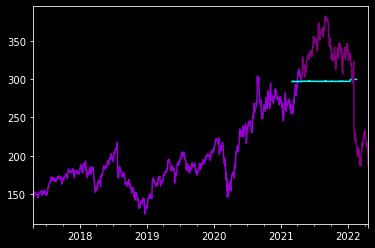

In [34]:
y_pred=arima_fit.forecast(exog=y_test[['events','DFF']], steps = len(y_test))

plt.grid(visible=True)
y_train['Close'].plot(color='darkviolet')
y_pred.plot(color='cyan')
y_test['Close'].plot(color = 'purple')
plt.xticks(rotation=0)
plt.style.use('dark_background')

In [103]:
y_test = y_test['Close']

mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')
mape = mean_absolute_percentage_error(y_test, y_pred, symmetric=False)
print(f'MAPE: {mape}')
smape = mean_absolute_percentage_error(y_test, y_pred)
print(f'SMAPE: {smape}')

MAE: 50.520557076780015
MSE: 3219.2705975467256
MAPE: 0.18011176378257265
SMAPE: 0.17197930633584974


## LSTM

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import BatchNormalization

Perform Min-Max Scaler

In [16]:
temp1 = np.array(data)

price = temp1[:,4].flatten()
max_price = max(price)
min_price = min(price)

vol = temp1[:,6].flatten()
max_vol = max(vol)
min_vol = min(vol)

dff = temp1[:,8].flatten()
max_dff = max(dff)
min_dff = min(dff)

df1_new = data.copy()
df1_new.iloc[:,4] = (df1_new.iloc[:,4]-min_price)/(max_price-min_price)
df1_new.iloc[:,6] = (df1_new.iloc[:,6]-min_vol)/(max_vol-min_vol)
df1_new.iloc[:,8] = (df1_new.iloc[:,8]-min_dff)/(max_dff-min_dff)

df1_new.head()

,Date,Open,High,Low,Close,Adj Close,Volume,events,DFF
2017-04-24,2017-04-24,144.960007,145.669998,144.339996,0.082946,145.470001,0.045920,0.0,0.360996
2017-04-25,2017-04-25,145.789993,147.149994,145.789993,0.086898,146.490005,0.064376,0.0,0.360996
2017-04-26,2017-04-26,147.089996,147.589996,146.089996,0.087169,146.559998,0.034869,0.0,0.360996
2017-04-27,2017-04-27,146.669998,147.750000,146.139999,0.091585,147.699997,0.028718,0.0,0.360996
2017-04-28,2017-04-28,149.500000,151.529999,149.070007,0.101464,150.250000,0.135143,0.0,0.327801


Generate training data

In [17]:
days = 60
test_num = 252
x = np.array(df1_new[['Close','Volume','events','DFF']])
y = x[:,0]
size = x.shape
all_x = np.zeros(shape=((size[0]-days),days,size[1]))
for i in range(size[0]-days):
    x_temp = x[i:i+days,:]
    all_x[i,:,:] = x_temp
all_y = y[days:]

X_train = all_x[:-test_num,:,:]
y_train = all_y[:-test_num]
X_test = all_x[-test_num:,:,:]
y_test = all_y[-test_num:]

In [316]:
X_train.shape

(947, 60, 4)

In [18]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, activation='relu', input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

In [31]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            11000     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [19]:
regressor.compile(optimizer = 'sgd', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 200, batch_size = 64)

Epoch 1/200
15/15 [==============================] - 31s 372ms/step - loss: 0.0548
Epoch 2/200
15/15 [==============================] - 5s 319ms/step - loss: 0.0316
Epoch 3/200
15/15 [==============================] - 5s 312ms/step - loss: 0.0297
Epoch 4/200
15/15 [==============================] - 5s 338ms/step - loss: 0.0289
Epoch 5/200
15/15 [==============================] - 4s 294ms/step - loss: 0.0283
Epoch 6/200
15/15 [==============================] - 5s 296ms/step - loss: 0.0271
Epoch 7/200
15/15 [==============================] - 5s 301ms/step - loss: 0.0263
Epoch 8/200
15/15 [==============================] - 5s 314ms/step - loss: 0.0255
Epoch 9/200
15/15 [==============================] - 5s 332ms/step - loss: 0.0246
Epoch 10/200
15/15 [==============================] - 5s 306ms/step - loss: 0.0242
Epoch 11/200
15/15 [==============================] - 5s 306ms/step - loss: 0.0234
Epoch 12/200
15/15 [==============================] - 5s 302ms/step - loss: 0.0231
Epoch 13/200

15/15 [==============================] - 5s 306ms/step - loss: 0.0051
Epoch 100/200
15/15 [==============================] - 4s 275ms/step - loss: 0.0049
Epoch 101/200
15/15 [==============================] - 5s 309ms/step - loss: 0.0048
Epoch 102/200
15/15 [==============================] - 5s 307ms/step - loss: 0.0049
Epoch 103/200
15/15 [==============================] - 4s 301ms/step - loss: 0.0050
Epoch 104/200
15/15 [==============================] - 5s 304ms/step - loss: 0.0046
Epoch 105/200
15/15 [==============================] - 4s 296ms/step - loss: 0.0048
Epoch 106/200
15/15 [==============================] - 5s 304ms/step - loss: 0.0045
Epoch 107/200
15/15 [==============================] - 4s 297ms/step - loss: 0.0046
Epoch 108/200
15/15 [==============================] - 5s 301ms/step - loss: 0.0045
Epoch 109/200
15/15 [==============================] - 5s 318ms/step - loss: 0.0047
Epoch 110/200
15/15 [==============================] - 5s 303ms/step - loss: 0.0043
Epoch 

15/15 [==============================] - 5s 324ms/step - loss: 0.0034
Epoch 197/200
15/15 [==============================] - 5s 313ms/step - loss: 0.0034
Epoch 198/200
15/15 [==============================] - 5s 320ms/step - loss: 0.0035
Epoch 199/200
15/15 [==============================] - 5s 316ms/step - loss: 0.0035
Epoch 200/200
15/15 [==============================] - 5s 329ms/step - loss: 0.0036


In [20]:
def inverse_scaler(x):
    return x * (max_price - min_price) + min_price

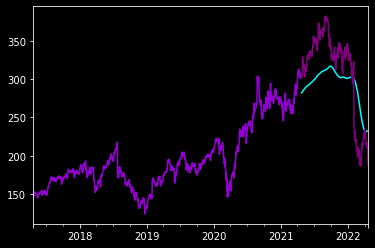

In [22]:
y_pred = regressor.predict(X_test)
y_pred = inverse_scaler(y_pred).reshape(-1)

y_pred = pd.Series(y_pred)
y_pred.index = data.iloc[1007:].index
y_train = data.iloc[:1006]['Close']
y_test = data.iloc[1007:][ 'Close']

plt.grid(visible=True)
y_train.plot(color='darkviolet')
y_pred.plot(color='cyan')
y_test.plot(color = 'purple')
plt.style.use('dark_background')

In [353]:
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')
mape = mean_absolute_percentage_error(y_test, y_pred, symmetric=False)
print(f'MAPE: {mape}')
smape = mean_absolute_percentage_error(y_test, y_pred)
print(f'SMAPE: {smape}')

MAE: 31.42226151050192
MSE: 1361.4548336207897
MAPE: 0.10761703621585357
SMAPE: 0.10578615659461364
